In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from keras.utils import to_categorical

In [5]:
def merge_history(models):
	data = dict()
	models_copy = models.copy()

	keys = list(models_copy[0].history.keys())
	values = list(models_copy[0].history.values())
	for i in range(len(keys)):
		data[keys[i]] = values[i]
	
	models_copy.pop(0)
	
	for el in models_copy:
		keys = list(el.history.keys())
		values = list(el.history.values())
		for i in range(len(keys)):
			for value in values[i]:
				data[keys[i]].append(value)
	return data

def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
 
	if isinstance(model,list):
		istoric = merge_history(model)
		if validation == True:
			val_to_plot = [istoric["val_"+el] for el in labels]
		to_plot = [istoric[el] for el in labels]
	else:
		if validation == True:
			val_to_plot = [model.history["val_"+el] for el in labels]
		to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

In [6]:
date = pd.read_csv("data/train.csv",delimiter=",")

Y = np.array(date[date.columns[0]].tolist())
Y = to_categorical(Y)

date = date.drop(['label'],axis=1)

X = np.array(date.values.tolist())/255.0
X = np.array([np.reshape(el,(28,28)) for el in X])
#X = np.array([np.reshape(el,(28,28,1)) for el in X])

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=35000,shuffle=True)

del date
del X
del Y

#plot_imagini_demo(train_X,train_Y,28)

In [11]:
print(test_X.shape)
print(test_Y.shape)
print(train_X.shape)
print(train_Y.shape)

(7000, 28, 28)
(7000, 10)
(35000, 28, 28)
(35000, 10)


In [12]:
print(train_X[:5])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [13]:
print(train_Y[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
	tf.keras.metrics.Precision(name='precision'),
	tf.keras.metrics.Recall(name='recall')
]
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, strides=2,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=METRICS)
model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,162,826 (4.44 MB)

 Trainable params: 1,161,994 (4.43 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
hist = model.fit(train_X,train_Y,epochs=16,batch_size=64,validation_data=(test_X,test_Y))

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.9929 - loss: 0.1168 - precision: 0.9706 - recall: 0.9583 - val_accuracy: 0.9963 - val_loss: 0.0639 - val_precision: 0.9829 - val_recall: 0.9797


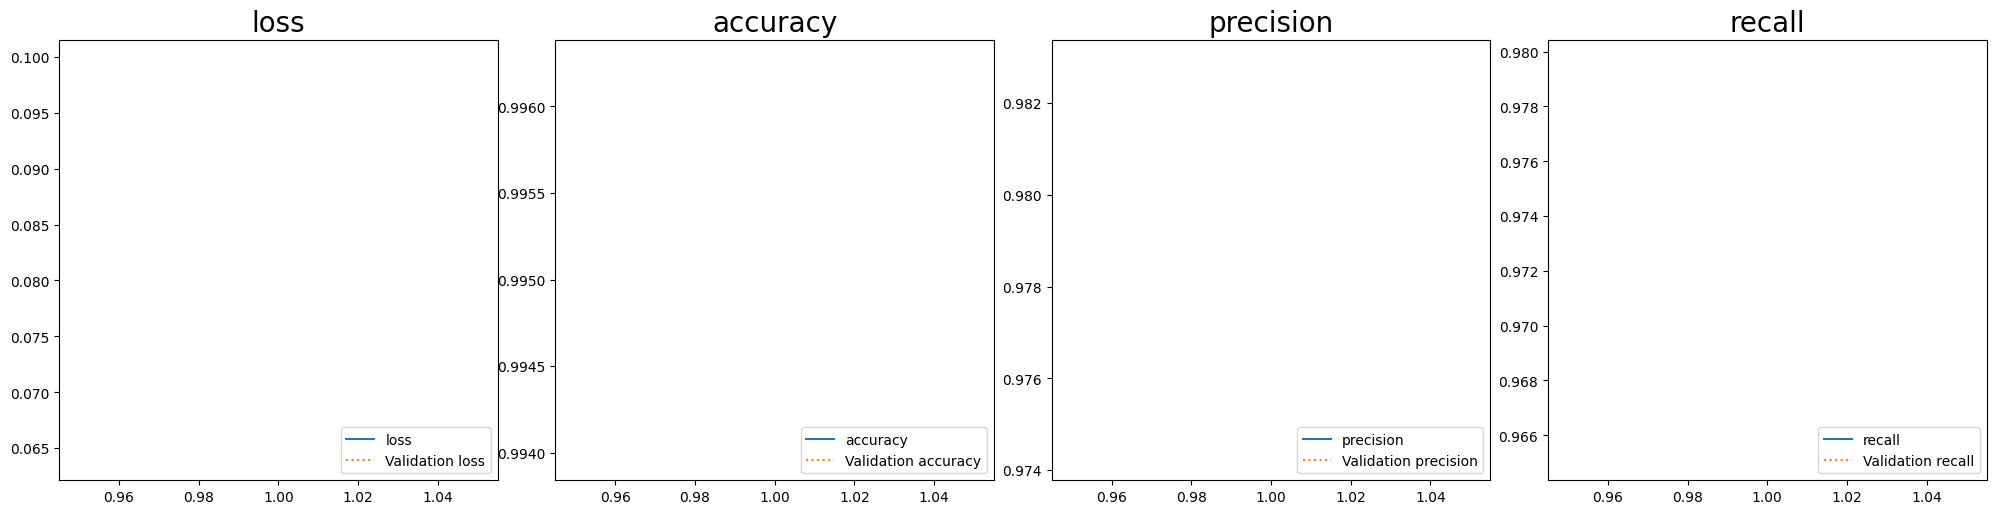

In [18]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],True)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy:  0.9812857142857143
Precision:  0.9814063011360972
Recall:  0.9809383759931279
F1 Score:  0.9810680765739338


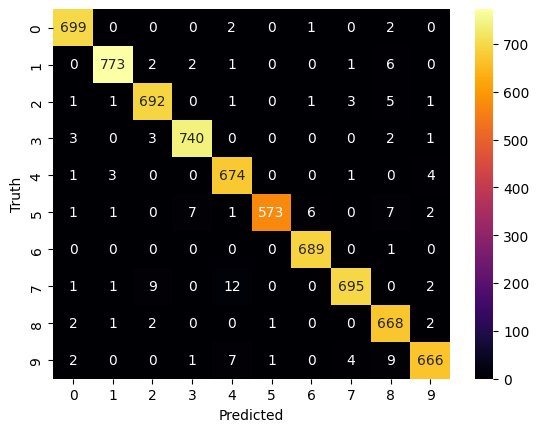

In [19]:
predicted = model.predict(test_X)
predicted = [np.argmax(el) for el in predicted]
actual = [np.argmax(el) for el in test_Y]

print("Accuracy: ",accuracy_score(actual,predicted))
print("Precision: ",precision_score(actual,predicted,average="macro"))
print("Recall: ",recall_score(actual,predicted,average="macro"))
print("F1 Score: ",f1_score(actual,predicted,average="macro"))

cm = confusion_matrix(actual, predicted)
sn.heatmap(cm, annot=True, fmt='d',cmap="inferno")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
date_test = pd.read_csv("data/test.csv",delimiter=",")
test_X = np.array(date_test.values.tolist())/255.0
test_X = np.array([np.reshape(el,(28,28)) for el in test_X])

y_predicted = model.predict(test_X)
predicted = [np.argmax(el) for el in y_predicted]

results = pd.Series(predicted,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),results],axis=1)
submission.to_csv("output.csv",index=False)


875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
